<a href="https://colab.research.google.com/github/jai2shan/TSAI_END2/blob/main/Session%203/Session_3_Pytorch%2097%20Accuracy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
from torchvision import datasets
datasets.MNIST('data', download=True)


Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn as nn
from tqdm import tqdm



In [9]:
train = torch.load("/content/data/MNIST/processed/training.pt")
randInt = torch.randint(0,9,(60000,))


class CustomLoader_MNIST(DataLoader):
    def __init__(self,pt_path):
        self.path = pt_path
        self.data = torch.load(self.path)
        

    def __getitem__(self, idx):
      if torch.is_tensor(idx):
        idx = idx.tolist()

      image, label = self.data[0][idx], self.data[1][idx] 

      randInt = torch.randint(0,9,(1,))
      x1, x2, y1, y2 = image.reshape(1,28,28), randInt, label, label + randInt[0]

      return x1, x2, y1, y2

    def __len__(self):
      return len(self.data[0])

train_data = CustomLoader_MNIST("/content/data/MNIST/processed/training.pt")
test_data = CustomLoader_MNIST("/content/data/MNIST/processed/test.pt")

In [10]:
torch.manual_seed(1)
batch_size = 1024
use_cuda = torch.cuda.is_available()

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, **kwargs)

In [30]:

dropout_value = 0.1

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 

        self.dropout = nn.Dropout(dropout_value)
        self.relu = nn.ReLU()
        self.ln1 = nn.Linear(11,30)
        self.ln2 = nn.Linear(30,19)

    def forward(self, img, rnum):        
        img = self.convblock1(img)
        img = self.convblock2(img)
        img = self.convblock3(img)
        img = self.pool1(img)
        img = self.convblock4(img)
        img = self.convblock5(img)
        img = self.convblock6(img)
        img = self.convblock7(img)
        img = self.gap(img)        
        img = self.convblock8(img)
        img = img.view(-1, 10)

        rnum = torch.cat((img, rnum), dim=1)
        rnum = self.ln1(rnum)
        rnum = self.relu(rnum)
        rnum = self.ln2(rnum)

        img = F.log_softmax(img, dim=-1)
        rnum = F.log_softmax(rnum, dim=-1)
        return img, rnum

In [31]:

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)

cuda


In [32]:
def train(model, device, train_loader, optimizer, epoch,loss1_,loss2_):

  model.train()
  pbar = tqdm(train_loader)
  correct1 = 0
  processed = 0
  correct2 = 0

  for batch_idx, (x1, x2, y1, y2) in enumerate(pbar):
    # Data
    x1, x2, y1, y2 = x1.float().to(device), x2.float().to(device), y1.to(device), y2.to(device)
    # Init
    
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict

    y1_pred, y2_pred = model(x1, x2)

    # Calculate loss
    loss1 = F.nll_loss(y1_pred, y1)
    loss2 = F.nll_loss(y2_pred, y2)

    # Cross Entropy Loss
    # loss1 = loss1_(y1_pred, y1)
    # loss2 = loss2_(y2_pred, y2)

    loss =  torch.add(loss1, loss2*2)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()


    
    pred1 = y1_pred.argmax(dim=1, keepdim=True)
    pred2 = y2_pred.argmax(dim=1, keepdim=True)
    
    # get the index of the max log-probability
    correct1 += pred1.eq(y1.view_as(pred1)).sum().item()
    correct2 += pred2.eq(y2.view_as(pred2)).sum().item()
    processed += len(x1)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy_digit={100*correct1/processed:0.2f} Accuracy_Rnum={100*correct2/processed:0.2f}')
    train_acc['Image'].append(100*correct1/processed)
    train_acc['RandomNumber'].append(100*correct2/processed)

def test(model, device, test_loader):
    model.eval()
    correct1 = 0
    correct2 = 0
    with torch.no_grad():
        for x1, x2, y1, y2 in test_loader:
            x1, x2, y1, y2 = x1.float().to(device), x2.float().to(device), y1.to(device), y2.to(device)
            y1_pred, y2_pred = model(x1, x2)
            
            pred1 = y1_pred.argmax(dim=1, keepdim=True)
            pred2 = y2_pred.argmax(dim=1, keepdim=True)
            correct1 += pred1.eq(y1.view_as(pred1)).sum().item()
            correct2 += pred2.eq(y2.view_as(pred2)).sum().item()

    print('Test set: Accuracy_digit={} Accuracy_Rnum={}'.format(100*correct1/len(test_loader.dataset),100*correct2/len(test_loader.dataset)))
    test_acc['Image'].append(100*correct1/len(test_loader.dataset))
    test_acc['RandomNumber'].append(100*correct2/len(test_loader.dataset))



def plot_performance(train_acc, test_acc):
  fig, axs = plt.subplots(2,2,figsize=(15,10))

  axs[0, 0].plot(train_acc['Image'])
  axs[0, 0].set_title("Training - Image")
  axs[0, 1].plot(train_acc['RandomNumber'])
  axs[0, 1].set_title("Training - Random Number Model")
  axs[1, 0].plot(test_acc['Image'])
  axs[1, 0].set_title("Test - Image")
  axs[1, 1].plot(test_acc['RandomNumber'])
  axs[1, 1].set_title("Test - Random Number Model")

  0%|          | 0/59 [00:00<?, ?it/s]

EPOCH: 0


Loss=6.755836486816406 Batch_id=58 Accuracy_digit=33.80 Accuracy_Rnum=9.44: 100%|██████████| 59/59 [00:02<00:00, 26.47it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=54.11 Accuracy_Rnum=12.02
EPOCH: 1


Loss=5.251306056976318 Batch_id=58 Accuracy_digit=68.58 Accuracy_Rnum=15.99: 100%|██████████| 59/59 [00:02<00:00, 26.58it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=77.89 Accuracy_Rnum=23.0
EPOCH: 2


Loss=3.8320465087890625 Batch_id=58 Accuracy_digit=89.23 Accuracy_Rnum=28.56: 100%|██████████| 59/59 [00:02<00:00, 26.21it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=93.03 Accuracy_Rnum=32.69
EPOCH: 3


Loss=3.1516544818878174 Batch_id=58 Accuracy_digit=95.23 Accuracy_Rnum=39.81: 100%|██████████| 59/59 [00:02<00:00, 26.01it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=96.16 Accuracy_Rnum=44.19
EPOCH: 4


Loss=2.806047201156616 Batch_id=58 Accuracy_digit=96.28 Accuracy_Rnum=47.33: 100%|██████████| 59/59 [00:02<00:00, 26.36it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=97.59 Accuracy_Rnum=53.55
EPOCH: 5


Loss=2.519233226776123 Batch_id=58 Accuracy_digit=96.86 Accuracy_Rnum=54.59: 100%|██████████| 59/59 [00:02<00:00, 25.79it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=97.47 Accuracy_Rnum=57.84
EPOCH: 6


Loss=2.3404245376586914 Batch_id=58 Accuracy_digit=97.11 Accuracy_Rnum=57.43: 100%|██████████| 59/59 [00:02<00:00, 25.96it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=97.52 Accuracy_Rnum=55.5
EPOCH: 7


Loss=2.1501219272613525 Batch_id=58 Accuracy_digit=97.31 Accuracy_Rnum=62.59: 100%|██████████| 59/59 [00:02<00:00, 26.15it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=97.65 Accuracy_Rnum=67.76
EPOCH: 8


Loss=2.007889986038208 Batch_id=58 Accuracy_digit=97.41 Accuracy_Rnum=66.17: 100%|██████████| 59/59 [00:02<00:00, 26.19it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.08 Accuracy_Rnum=71.54
EPOCH: 9


Loss=1.847692847251892 Batch_id=58 Accuracy_digit=97.56 Accuracy_Rnum=68.28: 100%|██████████| 59/59 [00:02<00:00, 26.28it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.37 Accuracy_Rnum=70.63
EPOCH: 10


Loss=1.850571632385254 Batch_id=58 Accuracy_digit=97.59 Accuracy_Rnum=70.01: 100%|██████████| 59/59 [00:02<00:00, 26.54it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.32 Accuracy_Rnum=68.71
EPOCH: 11


Loss=1.7507245540618896 Batch_id=58 Accuracy_digit=97.77 Accuracy_Rnum=72.13: 100%|██████████| 59/59 [00:02<00:00, 25.85it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.61 Accuracy_Rnum=81.29
EPOCH: 12


Loss=1.5641473531723022 Batch_id=58 Accuracy_digit=97.77 Accuracy_Rnum=74.23: 100%|██████████| 59/59 [00:02<00:00, 25.98it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=97.54 Accuracy_Rnum=73.12
EPOCH: 13


Loss=1.52789306640625 Batch_id=58 Accuracy_digit=97.91 Accuracy_Rnum=77.27: 100%|██████████| 59/59 [00:02<00:00, 25.62it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.14 Accuracy_Rnum=82.08
EPOCH: 14


Loss=1.5403313636779785 Batch_id=58 Accuracy_digit=97.99 Accuracy_Rnum=78.71: 100%|██████████| 59/59 [00:02<00:00, 25.24it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.4 Accuracy_Rnum=78.53
EPOCH: 15


Loss=1.461551547050476 Batch_id=58 Accuracy_digit=97.85 Accuracy_Rnum=79.12: 100%|██████████| 59/59 [00:02<00:00, 25.50it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.27 Accuracy_Rnum=84.24
EPOCH: 16


Loss=1.4168545007705688 Batch_id=58 Accuracy_digit=97.93 Accuracy_Rnum=80.29: 100%|██████████| 59/59 [00:02<00:00, 25.40it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.43 Accuracy_Rnum=85.18
EPOCH: 17


Loss=1.338045358657837 Batch_id=58 Accuracy_digit=98.05 Accuracy_Rnum=81.71: 100%|██████████| 59/59 [00:02<00:00, 25.27it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=97.89 Accuracy_Rnum=78.68
EPOCH: 18


Loss=1.429978370666504 Batch_id=58 Accuracy_digit=98.06 Accuracy_Rnum=80.73: 100%|██████████| 59/59 [00:02<00:00, 25.19it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.65 Accuracy_Rnum=84.41
EPOCH: 19


Loss=1.4114575386047363 Batch_id=58 Accuracy_digit=98.06 Accuracy_Rnum=82.39: 100%|██████████| 59/59 [00:02<00:00, 25.20it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.29 Accuracy_Rnum=92.74
EPOCH: 20


Loss=1.244084358215332 Batch_id=58 Accuracy_digit=98.13 Accuracy_Rnum=83.32: 100%|██████████| 59/59 [00:02<00:00, 26.19it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.63 Accuracy_Rnum=84.5
EPOCH: 21


Loss=1.202292561531067 Batch_id=58 Accuracy_digit=98.06 Accuracy_Rnum=86.38: 100%|██████████| 59/59 [00:02<00:00, 25.87it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.93 Accuracy_Rnum=83.84
EPOCH: 22


Loss=1.2076566219329834 Batch_id=58 Accuracy_digit=98.14 Accuracy_Rnum=85.31: 100%|██████████| 59/59 [00:02<00:00, 25.42it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.43 Accuracy_Rnum=85.19
EPOCH: 23


Loss=1.107951283454895 Batch_id=58 Accuracy_digit=98.25 Accuracy_Rnum=86.48: 100%|██████████| 59/59 [00:02<00:00, 25.22it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.93 Accuracy_Rnum=91.51
EPOCH: 24


Loss=1.1092272996902466 Batch_id=58 Accuracy_digit=98.32 Accuracy_Rnum=87.79: 100%|██████████| 59/59 [00:02<00:00, 25.66it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.82 Accuracy_Rnum=89.42
EPOCH: 25


Loss=0.9506547451019287 Batch_id=58 Accuracy_digit=98.27 Accuracy_Rnum=86.98: 100%|██████████| 59/59 [00:02<00:00, 25.72it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.9 Accuracy_Rnum=90.72
EPOCH: 26


Loss=1.1835558414459229 Batch_id=58 Accuracy_digit=98.24 Accuracy_Rnum=87.36: 100%|██████████| 59/59 [00:02<00:00, 25.10it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.93 Accuracy_Rnum=88.73
EPOCH: 27


Loss=1.1998004913330078 Batch_id=58 Accuracy_digit=98.37 Accuracy_Rnum=87.82: 100%|██████████| 59/59 [00:02<00:00, 25.98it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.99 Accuracy_Rnum=91.69
EPOCH: 28


Loss=1.1975579261779785 Batch_id=58 Accuracy_digit=98.31 Accuracy_Rnum=88.20: 100%|██████████| 59/59 [00:02<00:00, 25.42it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.58 Accuracy_Rnum=90.19
EPOCH: 29


Loss=0.9628446698188782 Batch_id=58 Accuracy_digit=98.35 Accuracy_Rnum=88.24: 100%|██████████| 59/59 [00:02<00:00, 25.16it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=99.01 Accuracy_Rnum=90.42
EPOCH: 30


Loss=1.1952534914016724 Batch_id=58 Accuracy_digit=98.41 Accuracy_Rnum=89.27: 100%|██████████| 59/59 [00:02<00:00, 25.09it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.86 Accuracy_Rnum=91.54
EPOCH: 31


Loss=1.0383206605911255 Batch_id=58 Accuracy_digit=98.45 Accuracy_Rnum=89.50: 100%|██████████| 59/59 [00:02<00:00, 25.72it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.87 Accuracy_Rnum=91.95
EPOCH: 32


Loss=0.8372334837913513 Batch_id=58 Accuracy_digit=98.42 Accuracy_Rnum=89.68: 100%|██████████| 59/59 [00:02<00:00, 25.43it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.95 Accuracy_Rnum=93.51
EPOCH: 33


Loss=0.960864782333374 Batch_id=58 Accuracy_digit=98.50 Accuracy_Rnum=91.14: 100%|██████████| 59/59 [00:02<00:00, 25.76it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.98 Accuracy_Rnum=94.37
EPOCH: 34


Loss=0.8447060585021973 Batch_id=58 Accuracy_digit=98.43 Accuracy_Rnum=91.03: 100%|██████████| 59/59 [00:02<00:00, 25.80it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=99.03 Accuracy_Rnum=91.62
EPOCH: 35


Loss=0.8646294474601746 Batch_id=58 Accuracy_digit=98.52 Accuracy_Rnum=90.86: 100%|██████████| 59/59 [00:02<00:00, 25.52it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.87 Accuracy_Rnum=92.7
EPOCH: 36


Loss=0.8434450030326843 Batch_id=58 Accuracy_digit=98.46 Accuracy_Rnum=92.09: 100%|██████████| 59/59 [00:02<00:00, 25.17it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.83 Accuracy_Rnum=93.49
EPOCH: 37


Loss=0.9970137476921082 Batch_id=58 Accuracy_digit=98.47 Accuracy_Rnum=90.55: 100%|██████████| 59/59 [00:02<00:00, 25.42it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.96 Accuracy_Rnum=95.16
EPOCH: 38


Loss=0.924053966999054 Batch_id=58 Accuracy_digit=98.50 Accuracy_Rnum=92.50: 100%|██████████| 59/59 [00:02<00:00, 25.49it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.73 Accuracy_Rnum=93.71
EPOCH: 39


Loss=0.9996893405914307 Batch_id=58 Accuracy_digit=98.46 Accuracy_Rnum=92.44: 100%|██████████| 59/59 [00:02<00:00, 24.76it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.93 Accuracy_Rnum=95.07
EPOCH: 40


Loss=1.4887751340866089 Batch_id=58 Accuracy_digit=98.61 Accuracy_Rnum=92.79: 100%|██████████| 59/59 [00:02<00:00, 24.72it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.44 Accuracy_Rnum=93.34
EPOCH: 41


Loss=0.8193753361701965 Batch_id=58 Accuracy_digit=98.55 Accuracy_Rnum=93.26: 100%|██████████| 59/59 [00:02<00:00, 24.74it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.89 Accuracy_Rnum=95.29
EPOCH: 42


Loss=0.6824755668640137 Batch_id=58 Accuracy_digit=98.63 Accuracy_Rnum=93.15: 100%|██████████| 59/59 [00:02<00:00, 24.43it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.89 Accuracy_Rnum=95.15
EPOCH: 43


Loss=0.6383476257324219 Batch_id=58 Accuracy_digit=98.68 Accuracy_Rnum=93.27: 100%|██████████| 59/59 [00:02<00:00, 24.21it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.99 Accuracy_Rnum=97.02
EPOCH: 44


Loss=0.754907488822937 Batch_id=58 Accuracy_digit=98.68 Accuracy_Rnum=93.89: 100%|██████████| 59/59 [00:02<00:00, 24.28it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=99.14 Accuracy_Rnum=96.17
EPOCH: 45


Loss=0.6917297840118408 Batch_id=58 Accuracy_digit=98.68 Accuracy_Rnum=93.44: 100%|██████████| 59/59 [00:02<00:00, 25.24it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=99.1 Accuracy_Rnum=95.21
EPOCH: 46


Loss=0.8665018677711487 Batch_id=58 Accuracy_digit=98.66 Accuracy_Rnum=92.86: 100%|██████████| 59/59 [00:02<00:00, 25.08it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=99.05 Accuracy_Rnum=95.11
EPOCH: 47


Loss=0.6552140712738037 Batch_id=58 Accuracy_digit=98.77 Accuracy_Rnum=94.16: 100%|██████████| 59/59 [00:02<00:00, 24.64it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=99.11 Accuracy_Rnum=95.48
EPOCH: 48


Loss=0.6150512099266052 Batch_id=58 Accuracy_digit=98.75 Accuracy_Rnum=93.48: 100%|██████████| 59/59 [00:02<00:00, 25.15it/s]
  0%|          | 0/59 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.94 Accuracy_Rnum=96.33
EPOCH: 49


Loss=0.4924432039260864 Batch_id=58 Accuracy_digit=98.75 Accuracy_Rnum=93.94: 100%|██████████| 59/59 [00:02<00:00, 24.97it/s]


Test set: Accuracy_digit=98.96 Accuracy_Rnum=97.0


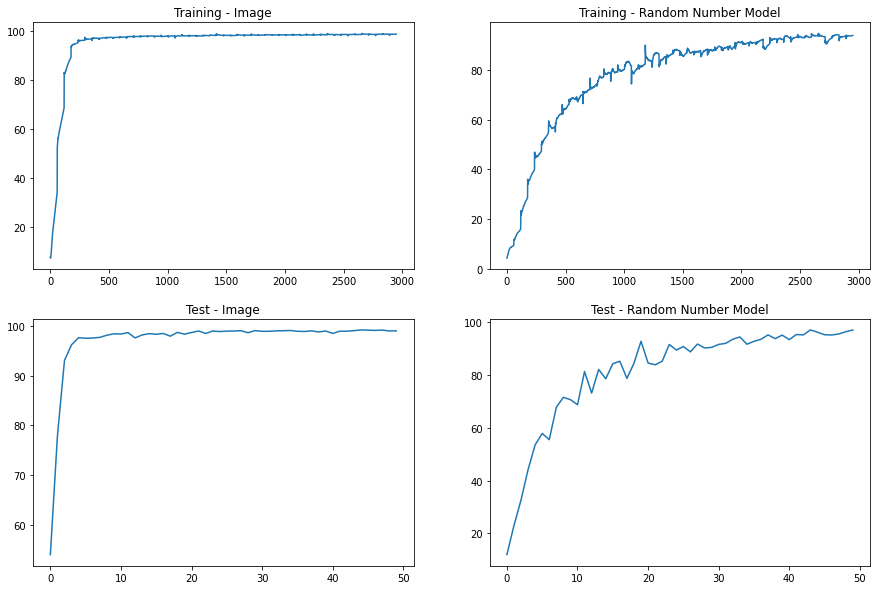

In [33]:
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim

train_losses = []
test_losses =  []
train_acc =  {'Image': [], 'RandomNumber': []}
test_acc = {'Image': [], 'RandomNumber': []}

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01,momentum=0.9)

loss1_ = nn.CrossEntropyLoss()
loss2_ = nn.CrossEntropyLoss()

EPOCHS = 50
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch,loss1_,loss2_)
    test(model, device, test_loader)

plot_performance(train_acc, test_acc)

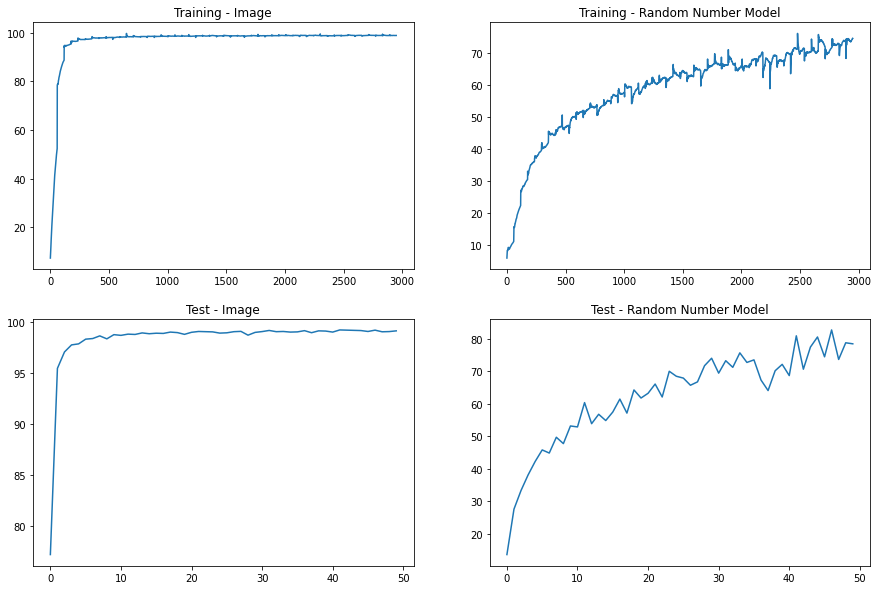